# **Résumé des étapes du projet**

## 1. Chargement des images et des ground truths :
- Importation des images d'entrée et des vérités terrain depuis les dossiers spécifiés.

## 2. Définition des pipelines de traitement :
- Création de **8 pipelines** en combinant différentes étapes : **Filtrage**, **Contraste**, et **Seuillage**.
- Chaque pipeline suit une séquence spécifique d'opérations.

## 3. Évaluation initiale des pipelines :
- Application des pipelines sur chaque image.
- Sélection du pipeline offrant la meilleure **F1-Score** pour chaque image.
- Attribution d’un pipeline optimal à chaque image en fonction des performances.

## 4. Extraction de caractéristiques :
- Extraction des caractéristiques des images, telles que :
  - **Histogramme des intensités**.
  - **LBP (Local Binary Pattern)**.
  - **Mesures statistiques** : niveau de bruit, intensité moyenne, entropie.

## 5. Entraînement d'un modèle SVM :
- Utilisation des caractéristiques extraites pour entraîner un modèle **SVM**.

## 6. Sélection du pipeline majoritaire :
- Identification du pipeline le plus fréquemment utilisé (**majority vote**) comme pipeline global pour tout le dataset.

## 7. Optimisation par apprentissage par renforcement (RL) :
- Création d’un environnement **Gym** pour ajuster dynamiquement les paramètres du pipeline majoritaire.
- Entraînement d’un agent RL  pour affiner les paramètres et améliorer les performances globales.

## 8. Évaluation finale :
- Application des paramètres optimisés sur l’ensemble du dataset.
- Calcul de la **F1-Score moyenne**.
- Sauvegarde des résultats des tests sur de nouvelles images et visualisation des résultats.




**1.   Importation des Bibliotheques**






In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import gymnasium as gym
from gymnasium import spaces
import random
import multiprocessing
from multiprocessing import Pool, cpu_count
import warnings
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import torch
from typing import Optional, Tuple
from tqdm import tqdm

**2. Chargement des images et des ground truths et Extraction des Features:**




In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_images_and_gt(images_folder, gt_folder):
    images = []
    gt_images = []
    filenames = []
    for filename in os.listdir(images_folder):
        if filename.lower().endswith(('.png')):
            image_path = os.path.join(images_folder, filename)
            gt_path = os.path.join(gt_folder, filename)
            image = cv2.imread(image_path)
            gt_image = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
            if image is not None and gt_image is not None:
                images.append(image)
                gt_images.append(gt_image)
                filenames.append(filename)
            else:
                print(f"Failed to load image or Ground Truth for {filename}")
    return images, gt_images, filenames

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray],[0],None,[256],[0,256]).flatten()
    if hist.sum() == 0:
        hist_norm = hist
    else:
        hist_norm = hist / hist.sum()

    lbp = feature.local_binary_pattern(gray, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0,10), range=(0, 9))
    if lbp_hist.sum() == 0:
        lbp_hist_norm = lbp_hist
    else:
        lbp_hist_norm = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)

    noise_level = np.std(gray)
    mean_intensity = np.mean(gray)
    entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-7))

    features = np.concatenate([hist_norm, lbp_hist_norm, [noise_level], [mean_intensity], [entropy]])
    return features

**3. Définition des pipelines de traitement:**

In [ ]:
def apply_pipeline(image, pipeline):
    processed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    for step in pipeline:
        stype = step['step_type']
        if stype == 'filter':
            ftype = step['filter_type']
            fparams = step['filter_params']
            if ftype == 'gaussian':
                k = fparams['ksize']
                processed = cv2.GaussianBlur(processed, (k, k), 0)
            elif ftype == 'median':
                k = fparams['ksize']
                processed = cv2.medianBlur(processed, k)
        elif stype == 'contrast':
            cmethod = step['contrast_method']
            cparams = step['contrast_params']
            if cmethod == 'hist_equalization':
                processed = cv2.equalizeHist(processed)
            elif cmethod == 'CLAHE':
                clip = cparams['clipLimit']
                tile = cparams['tileGridSize']
                clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile, tile))
                processed = clahe.apply(processed)
            elif cmethod == 'gamma_correction':
                gamma = cparams['gamma']
                invGamma = 1.0 / gamma
                table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype('uint8')
                processed = cv2.LUT(processed, table)
        elif stype == 'threshold':
            tmethod = step['threshold_method']
            tparams = step['threshold_params']
            if tmethod == 'global':
                thr = tparams['thresh']
                _, processed = cv2.threshold(processed, thr, 255, cv2.THRESH_BINARY)
            elif tmethod == 'otsu':
                _, processed = cv2.threshold(processed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            elif tmethod == 'adaptive':
                adaptMethod = tparams['adaptiveMethod']
                blockSize = tparams['blockSize']
                C = tparams['C']
                processed = cv2.adaptiveThreshold(processed, 255, adaptMethod, cv2.THRESH_BINARY, blockSize, C)
    return processed

def evaluate_segmentation(predicted, gt):
    edges_pred = cv2.Canny(predicted, 100, 200)
    edges_gt = cv2.Canny(gt, 100, 200)
    ep = (edges_pred > 0).astype(int)
    eg = (edges_gt > 0).astype(int)
    precision = precision_score(eg.flatten(), ep.flatten(), zero_division=0)
    recall = recall_score(eg.flatten(), ep.flatten(), zero_division=0)
    f1 = f1_score(eg.flatten(), ep.flatten(), zero_division=0)
    return precision, recall, f1

def define_pipelines():
    """
    Define 8 pipelines by permuting the three steps F (Filtrage), C (Contraste), T (Seuillage)!
    """
    # The 8 permutations of the three steps (+ repetition)
    permutations = [
        ('F', 'C', 'T'),
        ('F', 'T', 'C'),
        ('C', 'F', 'T'),
        ('C', 'T', 'F'),
        ('T', 'F', 'C'),
        ('T', 'C', 'F'),
        ('F', 'C', 'F'),
        ('C', 'T', 'C')
    ]

    filter_alg = {
        # Example: 'gaussian' with kernel size 5
        'filter_type': 'gaussian',
        'step_type': 'filter',
        'filter_params': {'ksize': 5}
    }

    filter_alg = {
        # Example: 'gaussian' with kernel size 5
        'filter_type': 'gaussian',
        'step_type': 'filter',
        'filter_params': {'ksize': 5}
    }


    contrast_alg = {
        # Example: 'hist_equalization' (no parameters)
        'contrast_method': 'hist_equalization',
        'step_type': 'contrast',
        'contrast_params': {}
    }


    threshold_alg = {
        # Example: 'global' with threshold=127
        'threshold_method': 'global',
        'step_type': 'threshold',
        'threshold_params': {'thresh': 127}
    }

    pipelines = {}
    pipeline_id = 1

    # For each of the 8 permutations
    for perm in permutations:
        # Build a list of steps (one for filter, contrast, threshold) in that order
        steps = []
        for step_char in perm:
            if step_char == 'F':
                steps.append(filter_alg)
            elif step_char == 'C':
                steps.append(contrast_alg)
            elif step_char == 'T':
                steps.append(threshold_alg)

        pipelines[f"pipeline_{pipeline_id}"] = [s.copy() for s in steps]
        pipeline_id += 1

    return pipelines

def initial_evaluation(images, gt_images, pipelines):
    """
    Evaluate all pipelines on each image and assign the best pipeline based on F1-Score.
    """
    pipeline_labels = []
    pipeline_keys = list(pipelines.keys())

    for idx, (img, gt) in enumerate(zip(images, gt_images)):
        best_f1 = -1
        best_pipeline = None

        for pname in pipeline_keys:
            pipeline = pipelines[pname]
            processed = apply_pipeline(img, pipeline)
            _, _, f1 = evaluate_segmentation(processed, gt)
            if f1 > best_f1:
                best_f1 = f1
                best_pipeline = pname

        pipeline_labels.append(best_pipeline)
        print(f"Best pipeline: {best_pipeline} fro Image {idx+1}/{len(images)} with  F1={best_f1:.4f}")

    return pipeline_labels

**Definition et Entraînement du modèle SVM:**

In [ ]:
def train_svm(X, pipeline_labels):
    """
    Train a Machine Learning Support Vector Machine (SVM) classifier to predict the best pipeline based on image features.
    """
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC

    le = LabelEncoder()
    y_encoded = le.fit_transform(pipeline_labels)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    svm_classifier = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
    svm_classifier.fit(X_train, y_train)

    acc = svm_classifier.score(X_test, y_test)
    print(f"SVM Accuracy: {acc:.4f}")

    return svm_classifier, le


In [ ]:
def pick_single_best_pipeline(pipeline_labels):
    """
    Pick the pipeline that appears most frequently among images.
    This becomes our single best pipeline for the entire dataset.
    """
    from collections import Counter
    counter = Counter(pipeline_labels)
    best_pipeline, _ = counter.most_common(1)[0]
    print(f"\nBest Pipeline for the whole dataset: {best_pipeline}")
    return best_pipeline

**Optimisation par apprentissage par renforcement (DQN):**

In [ ]:
class MultiImageEnv(gym.Env):
    def __init__(self, images, gt_images, pipeline, max_steps=20):
        super(MultiImageEnv, self).__init__()
        self.images = images
        self.gt_images = gt_images
        self.pipeline = pipeline
        self.max_steps = max_steps
        self.current_step = 0

        self.action_space = spaces.Discrete(50)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.current_params = self.get_initial_params()

    def get_initial_params(self):
        return [step.copy() for step in self.pipeline]

    def step(self, action):
        # Similar parameter modification logic as before
        filter_step = next((s for s in self.current_params if s['step_type'] == 'filter'), None)
        contrast_step = next((s for s in self.current_params if s['step_type'] == 'contrast'), None)

        if filter_step and filter_step['filter_type'] in ['gaussian','median']:
            if action == 0:
                filter_step['filter_params']['ksize'] = 3
            elif action == 1:
                filter_step['filter_params']['ksize'] = 5
            elif action == 2:
                filter_step['filter_params']['ksize'] = 7

        if contrast_step and contrast_step['contrast_method'] == 'CLAHE':
            if action == 10:
                contrast_step['contrast_params']['clipLimit'] = 2.0
            elif action == 11:
                contrast_step['contrast_params']['clipLimit'] = 4.0
            elif action == 12:
                contrast_step['contrast_params']['tileGridSize'] = 8
            elif action == 13:
                contrast_step['contrast_params']['tileGridSize'] = 16

        idx = random.randint(0, len(self.images)-1)
        img = self.images[idx]
        gt = self.gt_images[idx]

        processed = apply_pipeline(img, self.current_params)
        _, _, f1 = evaluate_segmentation(processed, gt)

        reward = f1
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False
        observation = np.array([0.0], dtype=np.float32)
        info = {'f1_score': f1}
        return observation, reward, terminated, truncated, info

    def reset(self, *, seed=None, options=None):
        self.current_step = 0
        self.current_params = self.get_initial_params()
        return np.array([0.0], dtype=np.float32), {}

    def render(self, mode='human'):
        pass

multiprocessing.set_start_method('spawn', force=True)

**Application de Traitement et Évaluation finale**

In [ ]:
set_seed(42)

images_folder = '/Users/pro/Downloads/images_inter'
gt_folder = '/Users/pro/Downloads/gt_edge_inter'

images, gt_images, filenames = load_images_and_gt(images_folder, gt_folder)
print(f"Loaded {len(images)} images...")

pipelines = define_pipelines()

Loaded 160 images...


In [ ]:
#Evaluate each pipeline on each image => best pipeline per image
pipeline_labels = initial_evaluation(images, gt_images, pipelines)

#Extract features
X = np.array([extract_features(img) for img in images])

#Train SVM => features → pipeline label
svm_classifier, le = train_svm(X, pipeline_labels)

#Now pick a single pipeline from these per-image labels
#    chosen method : majority vote
from collections import Counter
pipeline_count = Counter(pipeline_labels)
single_best_pipeline, _ = pipeline_count.most_common(1)[0]
print(f"\nSingle Best Pipeline (Majority Vote) across entire dataset: {single_best_pipeline}")


Image 1/160 => Best pipeline: pipeline_6 (F1=0.1492)
Image 2/160 => Best pipeline: pipeline_4 (F1=0.2033)
Image 3/160 => Best pipeline: pipeline_4 (F1=0.1725)
Image 4/160 => Best pipeline: pipeline_6 (F1=0.1845)
Image 5/160 => Best pipeline: pipeline_7 (F1=0.1480)
Image 6/160 => Best pipeline: pipeline_6 (F1=0.1701)
Image 7/160 => Best pipeline: pipeline_6 (F1=0.1574)
Image 8/160 => Best pipeline: pipeline_3 (F1=0.1682)
Image 9/160 => Best pipeline: pipeline_3 (F1=0.0488)
Image 10/160 => Best pipeline: pipeline_4 (F1=0.2129)
Image 11/160 => Best pipeline: pipeline_2 (F1=0.1311)
Image 12/160 => Best pipeline: pipeline_7 (F1=0.1548)
Image 13/160 => Best pipeline: pipeline_7 (F1=0.2263)
Image 14/160 => Best pipeline: pipeline_7 (F1=0.1795)
Image 15/160 => Best pipeline: pipeline_7 (F1=0.0950)
Image 16/160 => Best pipeline: pipeline_6 (F1=0.1921)
Image 17/160 => Best pipeline: pipeline_7 (F1=0.1479)
Image 18/160 => Best pipeline: pipeline_7 (F1=0.1877)
Image 19/160 => Best pipeline: pipeli

In [ ]:
#RL to tune parameters for that single pipeline across the entire dataset
best_pipeline_steps = pipelines[single_best_pipeline]
multi_env = MultiImageEnv(images, gt_images, best_pipeline_steps, max_steps=30)

In [ ]:
#RL training
agent = PPO('MlpPolicy', multi_env, verbose=0, device='cuda' if torch.cuda.is_available() else 'cpu')
print("\nTraining RL agent on single pipeline across the dataset...")
agent.learn(total_timesteps=400)


Training RL agent on single pipeline across the dataset...


In [ ]:
#Optimize once => get final pipeline parameters
obs, _ = multi_env.reset()
done, truncated = False, False
while not (done or truncated):
    action, _ = agent.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = multi_env.step(action)
final_params = multi_env.current_params

print("\nFinal tuned pipeline steps:")
for step in final_params:
    print(step)


Final tuned pipeline steps:
{'filter_type': 'gaussian', 'step_type': 'filter', 'filter_params': {'ksize': 5}}
{'contrast_method': 'hist_equalization', 'step_type': 'contrast', 'contrast_params': {}}
{'filter_type': 'gaussian', 'step_type': 'filter', 'filter_params': {'ksize': 5}}


In [ ]:
#Evaluate final pipeline on entire dataset
sum_f1 = 0
for i, (img, gt) in enumerate(zip(images, gt_images)):
    proc = apply_pipeline(img, final_params)
    _, _, f1 = evaluate_segmentation(proc, gt)
    sum_f1 += f1
avg_f1 = sum_f1 / len(images)
print(f"\nFinal average F1 after RL tuning on single best pipeline: {avg_f1:.4f}")


Final average F1 after RL tuning on single best pipeline: 0.1267


In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

def test_on_image(test_image_path, final_params, gt_folder, agent, multi_env, output_folder='test_results'):
    """
    Apply the final RL-tuned pipeline to a new image, display the original,
    ground truth, and processed (edges) images,
    and show the reward evolution during RL training.
    """
    if not os.path.isfile(test_image_path):
        print(f"Test image {test_image_path} does not exist.")
        return

    # Load the test image
    test_img = cv2.imread(test_image_path)
    if test_img is None:
        print(f"Failed to load test image {test_image_path}.")
        return

     # Load ground truth image
    base_name = os.path.basename(test_image_path)
    gt_path = os.path.join(gt_folder, base_name)

    if not os.path.isfile(gt_path):
      print(f"Ground Truth image {gt_path} does not exist.")
      return

    gt_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    if gt_img is None:
       print(f"Failed to load ground truth image {gt_path}.")
       return

    processed = apply_pipeline(test_img, final_params)
    edges_pred = cv2.Canny(processed, 100, 200)

    os.makedirs(output_folder, exist_ok=True)
    out_path = os.path.join(output_folder, f"test_{base_name}")
    cv2.imwrite(out_path, edges_pred)
    print(f"Saved edges result to {out_path}")

    edges_3ch = cv2.cvtColor(edges_pred, cv2.COLOR_GRAY2BGR)
    gt_3ch = cv2.cvtColor(gt_img, cv2.COLOR_GRAY2BGR)


    # Collect rewards during evaluation phase to display it in the graph
    obs, _ = multi_env.reset()
    done, truncated = False, False
    rewards = []
    while not (done or truncated):
        action, _ = agent.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = multi_env.step(action)
        rewards.append(reward)

    # Plot the images
    plt.figure(figsize=(18, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Ground Truth Image
    plt.subplot(2, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(cv2.cvtColor(gt_3ch, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Pipeline Output (Edges)
    plt.subplot(2, 3, 3)
    plt.title("Pipeline Output (Edges)")
    plt.imshow(cv2.cvtColor(edges_3ch, cv2.COLOR_BGR2RGB))
    plt.axis('off')

# Plot the reward evolution
    plt.subplot(2, 1, 2)  # Make it take up the full width
    plt.plot(rewards, linestyle='-')  # Solid line style
    plt.title("Reward Evolution During RL Tuning", fontsize=14) # Increase fontsize
    plt.xlabel("RL Step", fontsize=12) # Increase fontsize
    plt.ylabel("Reward (F1-Score)", fontsize=12) # Increase fontsize
    plt.grid(True)  # Add a grid
    plt.xticks(np.arange(0, len(rewards)+1, step = len(rewards)/5))
    plt.ylim(min(rewards) - 0.01, max(rewards) + 0.01)  # Set y-axis limits

    plt.tight_layout()
    plt.show()

**Comparaison entre Image Initiale/ Ground Truth/ Image avec le meilleur pipeline, et un graphe montrant l'evolution de Reward:**

Saved edges result to test_results/test_01005.png


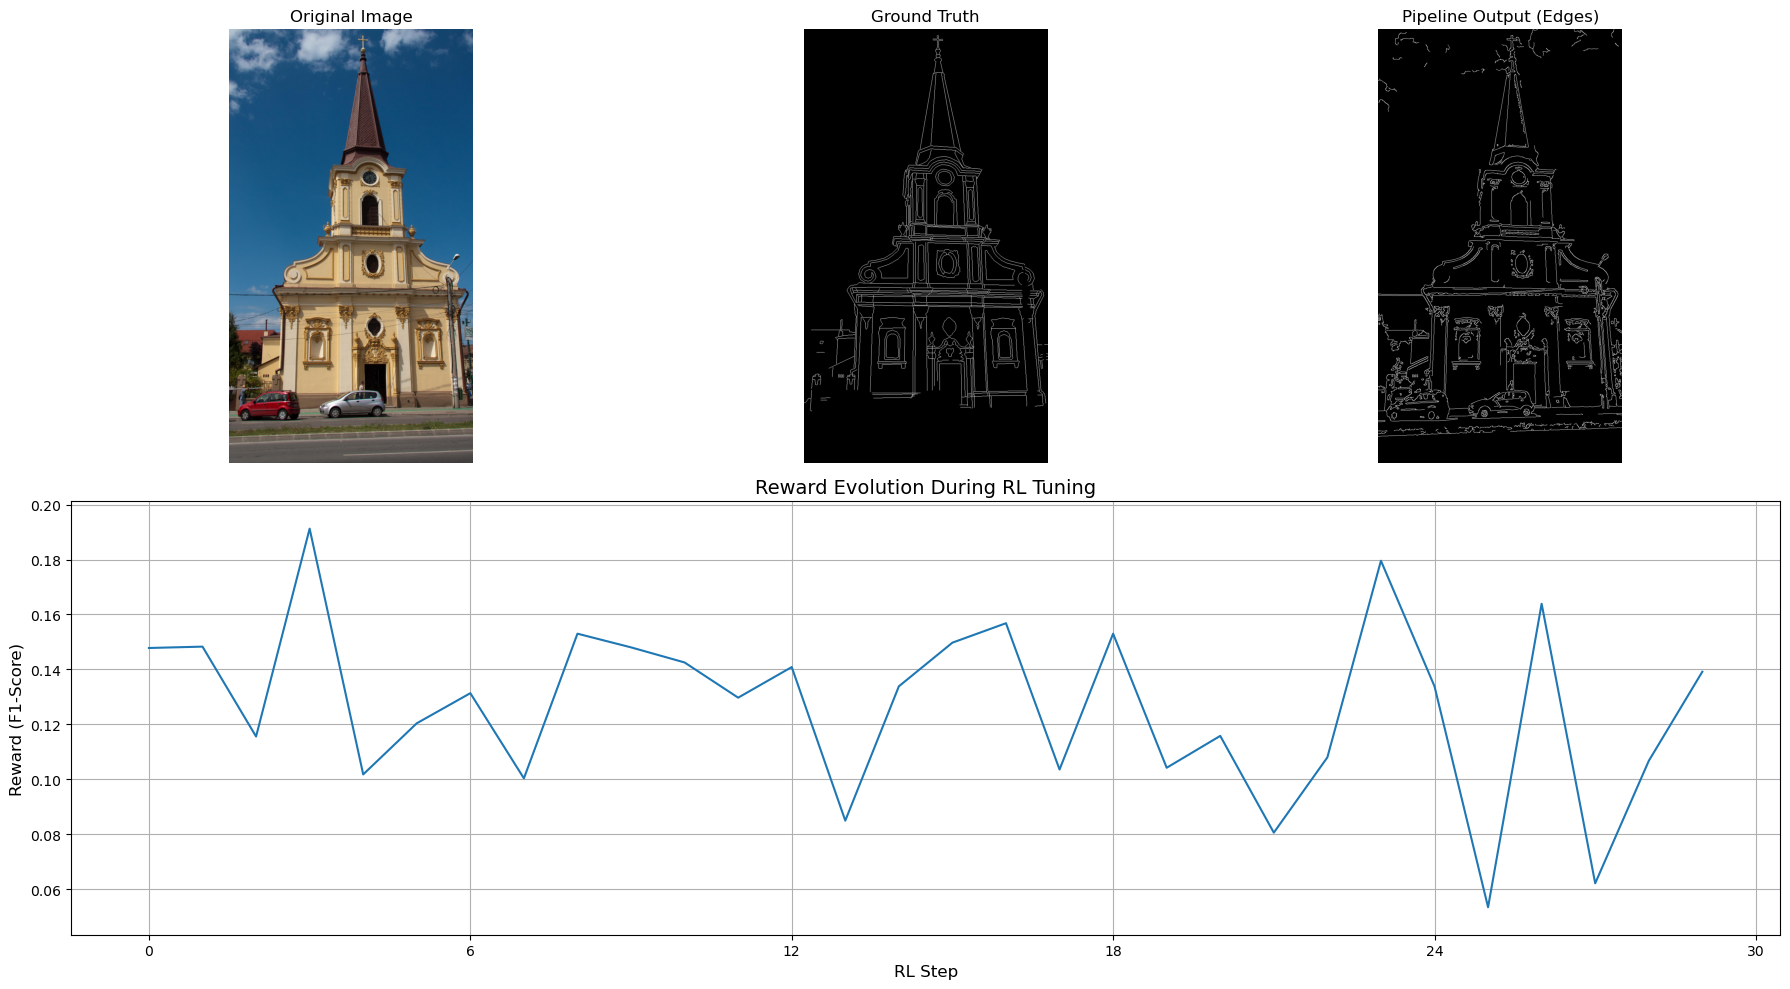

In [ ]:
test_image_path = "/Users/pro/Downloads/images_inter/01005.png"
gt_folder = '/Users/pro/Downloads/gt_edge_inter'
test_on_image(test_image_path, final_params, gt_folder, agent, multi_env)
